In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap as sp
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, auc
from sklearn.metrics import f1_score, make_scorer

from scipy import stats

import itertools

from catboost import CatBoostClassifier

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
#Check du type, de la proportion de N/A et du nombre de valeurs uniques pour chaque colonne

print(f"Dataset Shape: {df.shape}") 
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary = summary.reset_index()
summary['Missing'] = df.isnull().sum().values
summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
summary['Uniques'] = df.nunique().values
 
print('**Variable Description of  data:**')
summary

Dataset Shape: (253680, 22)
**Variable Description of  data:**


,index,dtypes,Missing,PercMissing,Uniques
0,Diabetes_012,float64,0,0.0,3
1,HighBP,float64,0,0.0,2
2,HighChol,float64,0,0.0,2
3,CholCheck,float64,0,0.0,2
4,BMI,float64,0,0.0,84
5,Smoker,float64,0,0.0,2
6,Stroke,float64,0,0.0,2
7,HeartDiseaseorAttack,float64,0,0.0,2
8,PhysActivity,float64,0,0.0,2
9,Fruits,float64,0,0.0,2


In [5]:
#Colonne Target
target_column = "Diabetes_012"

#Colonnes Numériques
numerical_columns = [
    'BMI', 'GenHlth', 'MentHlth', 'PhysHlth','Age', 'Education', 'Income'
]

#Colonnes Catégorielles
categorical_columns = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 
    'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]


#On force le type pour chaque type de colonnes
for l in numerical_columns: df[l] = df[l].astype('float')
for l in categorical_columns: df[l] = df[l].astype('string').fillna("None").astype('category')
df[target_column] = df[target_column].astype('int')

#On ordonne notre df
df = df[ [target_column] + numerical_columns + categorical_columns ]

#On supprime les lignes ou la target est n/a
df = df.dropna(subset=target_column)

In [6]:
df.describe()

,Diabetes_012,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,28.382364,2.511392,3.184772,4.242081,8.032119,5.050434,6.053875
std,0.698160,6.608694,1.068477,7.412847,8.717951,3.054220,0.985774,2.071148
min,0.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,24.000000,2.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,27.000000,2.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,31.000000,3.000000,2.000000,3.000000,10.000000,6.000000,8.000000
max,2.000000,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


In [7]:
corr=df[numerical_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
BMI,1.000000,0.239185,0.085310,0.121141,-0.036618,-0.103932,-0.100069
GenHlth,0.239185,1.000000,0.301674,0.524364,0.152450,-0.284912,-0.370014
MentHlth,0.085310,0.301674,1.000000,0.353619,-0.092068,-0.101830,-0.209806
PhysHlth,0.121141,0.524364,0.353619,1.000000,0.099130,-0.155093,-0.266799
Age,-0.036618,0.152450,-0.092068,0.099130,1.000000,-0.101901,-0.127775
Education,-0.103932,-0.284912,-0.101830,-0.155093,-0.101901,1.000000,0.449106
Income,-0.100069,-0.370014,-0.209806,-0.266799,-0.127775,0.449106,1.000000


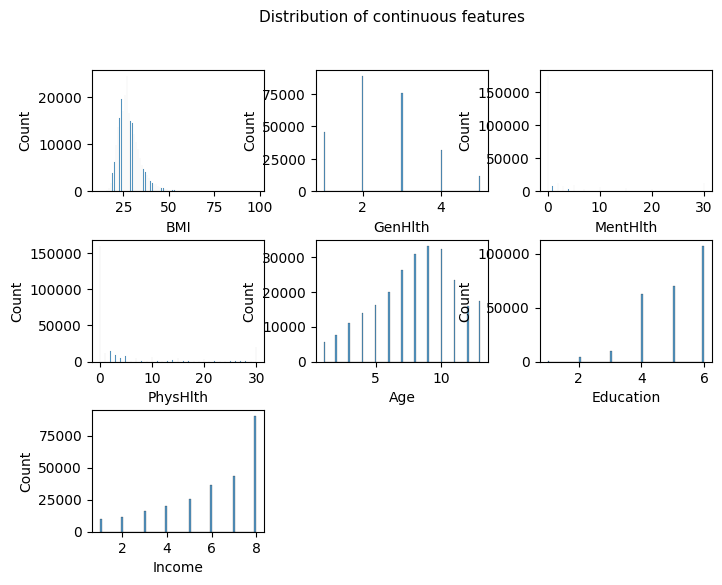

In [8]:
nb_cols=3
fig = plt.figure(figsize=(8,6))
fig.suptitle('Distribution of continuous features', fontsize=11)
gs = fig.add_gridspec(int(np.ceil(len(numerical_columns)/nb_cols)),nb_cols)
gs.update(wspace=0.3, hspace=0.4)
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
    sns.histplot(df[col], ax=ax)

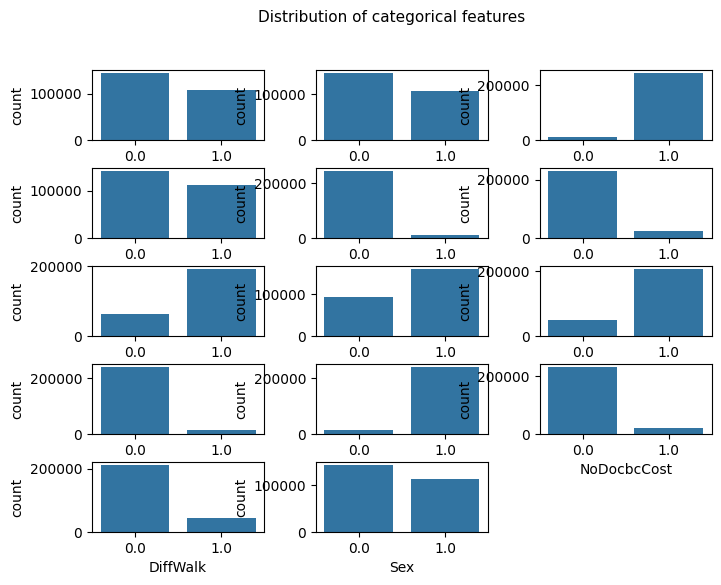

In [9]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Distribution of categorical features', fontsize=11)
gs = fig.add_gridspec(int(np.ceil(len(categorical_columns)/nb_cols)),nb_cols)
gs.update(wspace=0.3, hspace=0.4)
for i, col in enumerate(categorical_columns):
    ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
    plot = sns.countplot(df, x=col)

In [10]:
#Train/test split
 
X = df.drop(target_column, axis=1)
y = df[target_column]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
n_train=y.size
n_test=y_test.size
 
n,p=X.shape
n_classes= np.unique(y).size
 
#matrice des probas
lb = LabelBinarizer().fit(y)
Y_train = lb.transform(y_train) 
Y_test = lb.transform(y_test) 
 
print("Kolmogorov p_value (train/test même distrib):", np.round(stats.ks_2samp(y_train, y_test)[1],3))
print("Shape of train X,y,Y: ",X_train.shape, y_train.shape, Y_train.shape)
print("Shape of test X,y,Y: ",X_test.shape, y_test.shape, Y_test.shape)
print("Number of classes: ", n_classes)

Kolmogorov p_value (train/test même distrib): 1.0
Shape of train X,y,Y:  (202944, 21) (202944,) (202944, 3)
Shape of test X,y,Y:  (50736, 21) (50736,) (50736, 3)
Number of classes:  3


In [11]:
#On vérifie le ratio 0/1 dans nos échantillons train et test:

Balance_train = np.unique(y_train, return_counts=True)
Prop_train = Balance_train[1]/np.sum(Balance_train[1])
 
Balance_test = np.unique(y_test, return_counts=True)
Prop_test = Balance_test[1]/np.sum(Balance_test[1])
 
print("Balance_train:", Balance_train)
print("Balance_test:", Balance_test)
print("-"*80)
print("Prop_train:", Prop_train)
print("Prop_test:", Prop_test)

Balance_train: (array([0, 1, 2]), array([170908,   3687,  28349], dtype=int64))
Balance_test: (array([0, 1, 2]), array([42795,   944,  6997], dtype=int64))
--------------------------------------------------------------------------------
Prop_train: [0.84214365 0.01816757 0.13968878]
Prop_test: [0.84348392 0.01860612 0.13790997]


In [12]:
def decision(Y, thresholds = None):
    if(thresholds is None): return np.argmax(Y, axis=1)
    else:
        classes_ordered = pd.DataFrame(Balance_train[1], index = Balance_train[0]).sort_values(0).index
        y = np.ones(Y[:,0].size) * -1
        for i in range(n_classes-1): 
            y = np.where((Y[:,classes_ordered[i]]>thresholds[i]) & (y==-1), classes_ordered[i], y)
        y = np.where(y !=-1, y, classes_ordered[-1])
        return y

In [13]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 250, 750),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.5, 3, log=True),
        "threshold1": trial.suggest_float("threshold1", 1e-2, 0.2, log=True),
        "threshold2": trial.suggest_float("threshold2", 1e-2, 0.5, log=True),
    }

    clf_catboost_cv = CatBoostClassifier(logging_level='Silent',
                                      iterations=params["iterations"], learning_rate=params["learning_rate"], 
                                      depth=params["depth"], l2_leaf_reg=params["l2_leaf_reg"],
                                      cat_features = categorical_columns)
    
    def f1_seuil(y_true, y_pred):
        y_pred = decision(y_pred, thresholds = [params["threshold1"], params["threshold2"]])
        return f1_score(y_true, y_pred, average="macro")
    
    return cross_val_score(clf_catboost_cv, X_train, y_train, cv = 5, 
                           scoring= make_scorer(f1_seuil, needs_proba=True)).mean()

In [14]:
'''
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
params = study.best_params
print('Best hyperparameters:', params)
print('Best F1-score:', study.best_value)
''';

params = {'iterations': 408, 'learning_rate': 0.01869076654163222, 'depth': 6, 'l2_leaf_reg': 1.8763709074112733, 'threshold1': 0.048876161598874056, 'threshold2': 0.2269638861921709}

In [15]:
clf_catboost = CatBoostClassifier(iterations=params["iterations"], learning_rate=params["learning_rate"], 
                                    depth=params["depth"], l2_leaf_reg=params["l2_leaf_reg"],
                                    cat_features = categorical_columns)

clf_catboost = clf_catboost.fit(X_train, y_train, verbose = False, plot=True, eval_set= (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
#Result model:

#Probabilités
Y_hat_train = clf_catboost.predict_proba(X_train)
Y_hat_test = clf_catboost.predict_proba(X_test)

#Labels
y_hat_train = decision(Y_hat_train, [params["threshold1"], params["threshold2"]]) 
y_hat_test = decision(Y_hat_test, [params["threshold1"], params["threshold2"]]) 

In [17]:
#Loss
print("Train loss: ", log_loss(Y_train, Y_hat_train))
print("Test loss: ", log_loss(Y_test, Y_hat_test))
 
print("Test loss (random): ", log_loss(Y_test, np.ones((n_test, n_classes))*Prop_test))

Train loss:  0.3915338984149509
Test loss:  0.3903744351893757
Test loss (random):  0.49092575907473834


Classe 0:
AUC ROC:  0.829
AUC PR: CatBoost:  0.961 VS Random: 0.843 

Classe 1:
AUC ROC:  0.706
AUC PR: CatBoost:  0.037 VS Random: 0.019 

Classe 2:
AUC ROC:  0.835
AUC PR: CatBoost:  0.433 VS Random: 0.138 



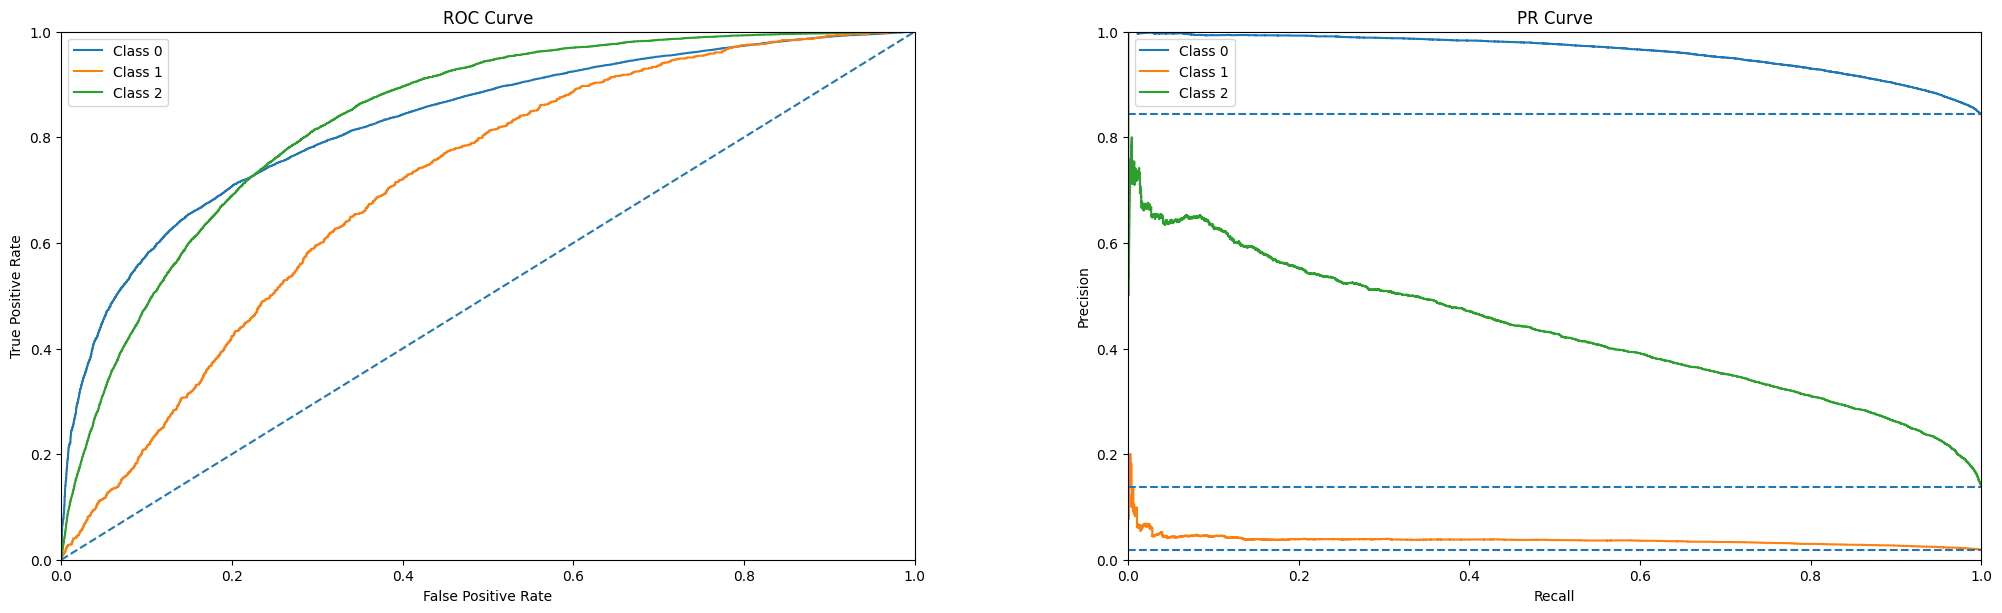

In [18]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(Y_test[:, i], Y_hat_test[:, i])
    PrecisionRecallDisplay(precision= precision, recall= recall).plot(ax = ax1, label = "Class "+str(i)) 
    ax1.axhline(y=Prop_test[i], linestyle="--", label='_Random Classifier')
    
    fpr, tpr, _ = roc_curve(Y_test[:, i], Y_hat_test[:, i])
    RocCurveDisplay(fpr= fpr, tpr= tpr).plot(ax = ax0, label = "Class "+str(i))
    print("Classe "+str(i)+":")
    print("AUC ROC: ", np.round(auc(fpr, tpr),3))
    print("AUC PR: CatBoost: ", np.round(auc(recall, precision),3), "VS Random:", np.round(Prop_test[i],3), "\n")
    
ax0.axline((0, 0), slope=1, linestyle = "--", label = '_Random Classfier')
ax0.legend(), ax0.set(xlim=(0, 1), ylim=(0, 1), title="ROC Curve")

ax1.legend(), ax1.set(xlim=(0, 1), ylim=(0, 1), title="PR Curve")


plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

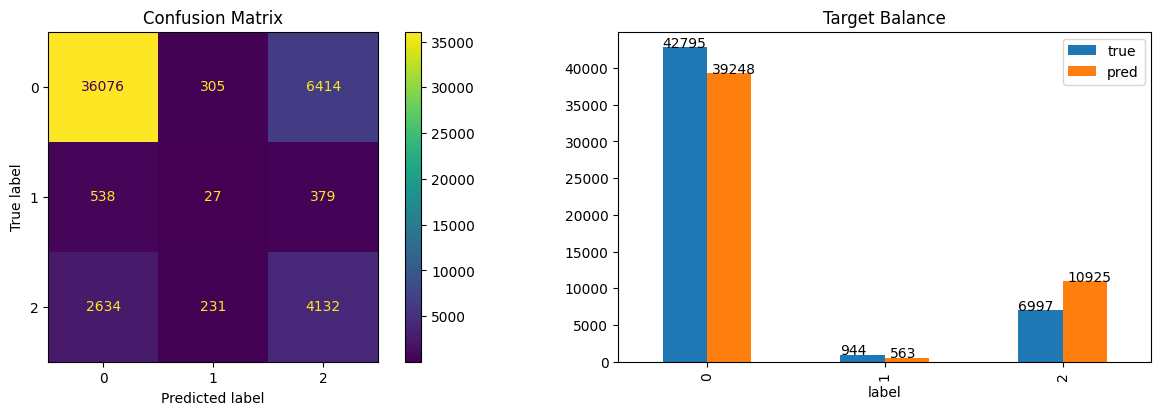

In [19]:
conf_matrix = confusion_matrix(y_test, y_hat_test)

balance = pd.DataFrame(Balance_test, ["label", "true"]).T.set_index("label") \
            .merge(pd.DataFrame(np.unique(y_hat_test, return_counts=True), ["label", "pred"]).T.set_index("label"), how="left", on="label") \
            .fillna(0).astype("int")

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(4, 3))  # Adjust the size as needed
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = Balance_train[0].astype("str") )
cm_display.plot(ax=ax0)
ax0.set_title('Confusion Matrix')

balance.plot(ax=ax1, kind='bar')
for i in range(n_classes):
    ax1.text(i-0.25, balance.loc[i,"true"], balance.loc[i,"true"])
    ax1.text(i+0.03, balance.loc[i,"pred"], balance.loc[i,"pred"])
ax1.set_title('Target Balance')


plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

In [20]:
print(classification_report(y_test, y_hat_test, target_names = Balance_train[0].astype("str"), zero_division = 0))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     42795
           1       0.05      0.03      0.04       944
           2       0.38      0.59      0.46      6997

    accuracy                           0.79     50736
   macro avg       0.45      0.49      0.46     50736
weighted avg       0.83      0.79      0.81     50736



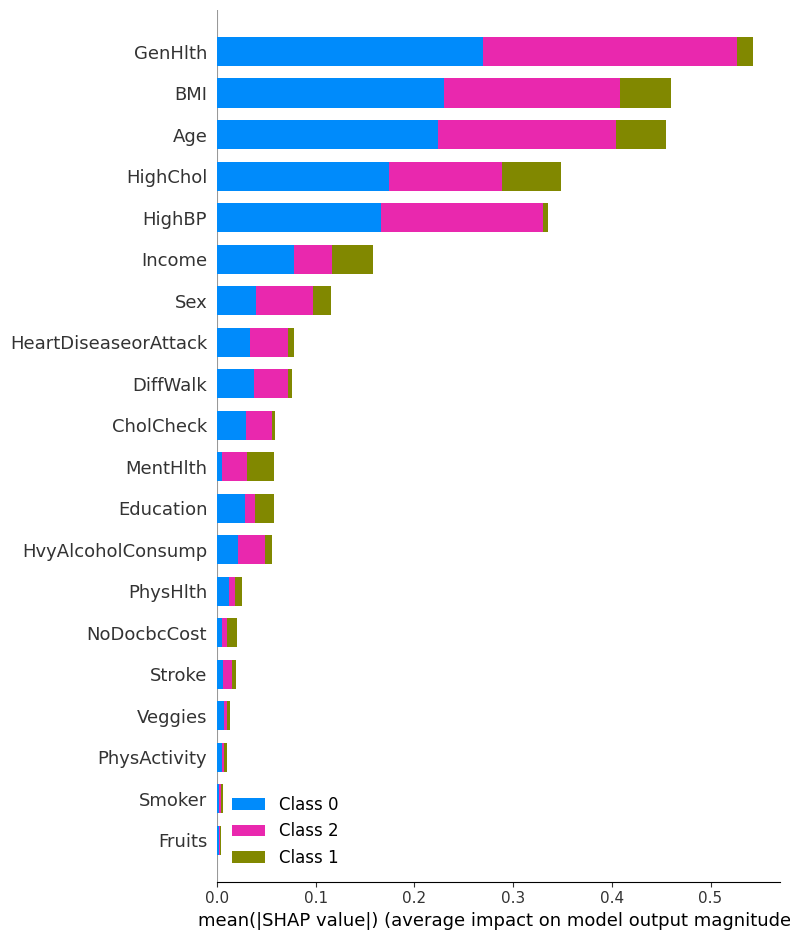

In [21]:
explainer = sp.TreeExplainer(clf_catboost)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train)